<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/Pytorch_gradCAM_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
from io import BytesIO

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

    def forward(self, x):
        self.activation = None
        self.gradients = None

        def save_activation(module, input, output):
            self.activation = output.detach()

        def save_gradient(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(save_activation)
        self.target_layer.register_backward_hook(save_gradient)

        output = self.model(x)
        return output

    def generate_cam(self, idx):
        self.model.zero_grad()
        output = self.model(x)
        output[0, idx].backward()

        weights = torch.mean(self.gradients, dim=[2, 3])
        cam = torch.sum(weights[:, :, None, None] * self.activation, dim=1).squeeze()
        cam = F.relu(cam)
        cam = cam / torch.max(cam)
        return cam.cpu().numpy()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


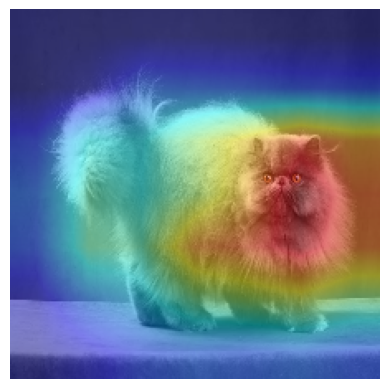

In [9]:
model = models.resnet50(pretrained=True)
model.eval()
target_layer = model.layer4[-1]
gradcam = GradCAM(model, target_layer)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_url = "https://www.thesprucepets.com/thmb/Qt7k6w4eikK9ZDKULTEX7YEaAZs=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/GettyImages-181861505-4e63227ed0a14dc9bfe86848ef54caf3.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
x = transform(img).unsqueeze(0)

output = gradcam.forward(x)
idx = output.argmax().item()
cam = gradcam.generate_cam(idx)

img = np.array(img)
img = cv2.resize(img, (224, 224))

# heatmapのサイズを入力画像と同じサイズに変更
heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
result = heatmap * 0.4 + img * 0.6
result = result / np.max(result)

plt.imshow(result)
plt.axis('off')
plt.show()

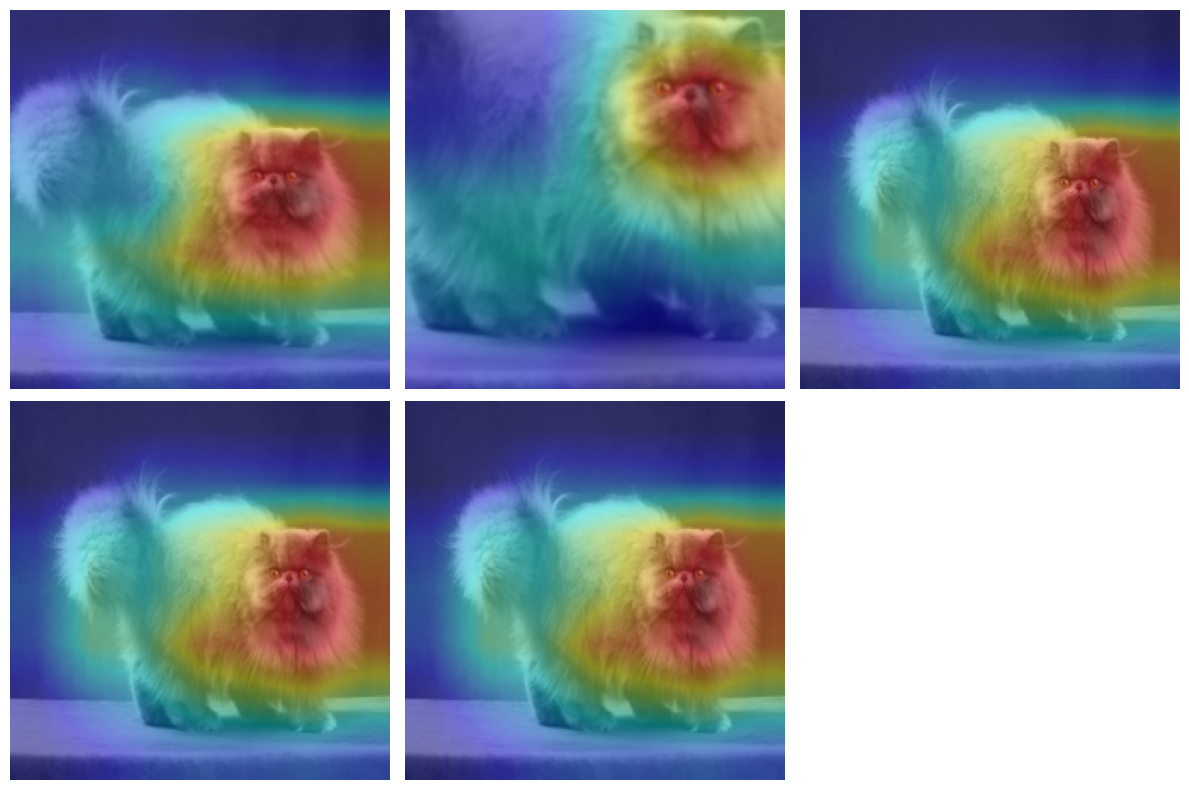

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
from io import BytesIO

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

    def forward(self, x):
        self.activation = None
        self.gradients = None

        def save_activation(module, input, output):
            self.activation = output.detach()

        def save_gradient(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(save_activation)
        self.target_layer.register_backward_hook(save_gradient)

        output = self.model(x)
        return output

    def generate_cam(self, idx):
        self.model.zero_grad()
        output = self.model(x)
        output[0, idx].backward()

        weights = torch.mean(self.gradients, dim=[2, 3])
        cam = torch.sum(weights[:, :, None, None] * self.activation, dim=1).squeeze()
        cam = F.relu(cam)
        cam = cam / torch.max(cam)
        return cam.cpu().numpy()

model = models.resnet50(pretrained=True)
model.eval()
target_layer = model.layer4[-1]
gradcam = GradCAM(model, target_layer)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.1, 10.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_url = "https://www.thesprucepets.com/thmb/Qt7k6w4eikK9ZDKULTEX7YEaAZs=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/GettyImages-181861505-4e63227ed0a14dc9bfe86848ef54caf3.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

def unnormalize(img, mean, std):
    img = img.clone()  # 元のテンソルを変更しないためにコピー
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

for i in range(5):
    x = transform(img).unsqueeze(0)
    output = gradcam.forward(x)
    idx = output.argmax().item()
    cam = gradcam.generate_cam(idx)

    img_processed = unnormalize(x.squeeze(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_processed = img_processed.permute(1, 2, 0).numpy()
    img_processed = np.clip(img_processed, 0, 1)  # 値を0から1の範囲にクリップ

    heatmap = cv2.resize(cam, (img_processed.shape[1], img_processed.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 画像の範囲を0から255にスケーリングして正規化
    img_processed_255 = (img_processed * 255).astype(np.uint8)
    result = heatmap * 0.4 + img_processed_255 * 0.6
    result = np.clip(result, 0, 255).astype(np.uint8)  # 値を0から255の範囲にクリップ

    axs[i].imshow(result)
    axs[i].axis('off')

axs[-1].remove()
plt.tight_layout()
plt.show()
